In [1]:
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.analysis_basics import check_constraints as check
from src.utils.rolling_process.rolling_filter import *

# Solver
from src.solvers.converter import get_schedule_dframe, get_job_ops_dict, get_times_dict
from src.solvers.lp.tardiness import solve_jssp_sum_tardiness_minimization

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Hard termination condition for schedulers
max_time = 60*15     # 15 min

# File paths
logs_path = get_path("data", "logs")
basic_data_path = get_path("data", "basic")

In [3]:
# Load file
df_routings = pd.read_csv(basic_data_path / "routings_ft10.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


### Load job-shop scheduling problem and the associated jobs information (15 Jobs)

In [4]:
df_jobs_times_final = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times = df_jobs_times_final.head(15)
df_jobs_times


,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
1,J25-0001,6,129,1440,416,2338
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
6,J25-0006,9,790,1440,540,3539
7,J25-0007,5,925,1440,496,2929
8,J25-0008,4,988,1440,393,3541
9,J25-0009,7,1004,1440,539,3578


In [5]:
basic_data_path = get_path("data", "basic")
df_jssp_final = pd.read_csv(basic_data_path / "jssp_final.csv")

df_jssp = df_jssp_final[df_jssp_final["Job"].isin(df_jobs_times["Job"])]
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
144,J25-0014,4,4,M03,26
145,J25-0014,4,5,M04,69
146,J25-0014,4,6,M08,21


### Scheduling Preparation

In [6]:
job_ops = get_job_ops_dict(df_jssp)
job_ops

{'J25-0000': [(0, 'M00', 76),
  (1, 'M01', 69),
  (2, 'M03', 76),
  (3, 'M05', 51),
  (4, 'M02', 85),
  (5, 'M09', 11),
  (6, 'M06', 40),
  (7, 'M07', 89),
  (8, 'M04', 26),
  (9, 'M08', 74)],
 'J25-0001': [(0, 'M01', 46),
  (1, 'M00', 37),
  (2, 'M03', 61),
  (3, 'M02', 13),
  (4, 'M06', 32),
  (5, 'M05', 21),
  (6, 'M09', 32),
  (7, 'M08', 89),
  (8, 'M07', 30),
  (9, 'M04', 55)],
 'J25-0002': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0003': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0004': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0005': [(0, 'M00', 43),
  (1, '

In [7]:
times_dict = get_times_dict(df_jobs_times, earliest_start_column="Ready Time")
times_dict

{'J25-0000': (1440, 3660),
 'J25-0001': (1440, 2338),
 'J25-0002': (1440, 3744),
 'J25-0003': (1440, 3379),
 'J25-0004': (1440, 4856),
 'J25-0005': (1440, 3106),
 'J25-0006': (1440, 3539),
 'J25-0007': (1440, 2929),
 'J25-0008': (1440, 3541),
 'J25-0009': (1440, 3578),
 'J25-0010': (1440, 3345),
 'J25-0011': (1440, 3210),
 'J25-0012': (1440, 4385),
 'J25-0013': (1440, 2567),
 'J25-0014': (1440, 3315)}

## Scheduling

### HiGHS with PuLP
> high performance serial and parallel solver


In [8]:
log_file_path = logs_path / "tardiness_highs.log" if logs_path else None

schedule = solve_jssp_sum_tardiness_minimization(
    job_ops=job_ops,
    times_dict=times_dict,
    solver_type="HiGHS",
    msg=False,
    solver_time_limit=max_time,
    solver_relative_gap_limit=0.01,
    log_file=log_file_path
)


Solver Information:
  Status                   : Optimal
  Objective value          : 0.0
  Runtime                  : 17.3
  Num variables            : 1230
  Num constraints          : 2280


In [9]:
df_schedule = get_schedule_dframe(schedule)
df_schedule

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,2539.0,76,2615.0
1,J25-0000,1,M01,2911.0,69,2980.0
2,J25-0000,2,M03,2991.0,76,3067.0
3,J25-0000,3,M05,3104.0,51,3155.0
4,J25-0000,4,M02,3155.0,85,3240.0
5,J25-0000,5,M09,3268.0,11,3279.0
...,...,...,...,...,...,...
144,J25-0014,4,M03,1604.0,26,1630.0
145,J25-0014,5,M04,1630.0,69,1699.0
146,J25-0014,6,M08,1699.0,21,1720.0


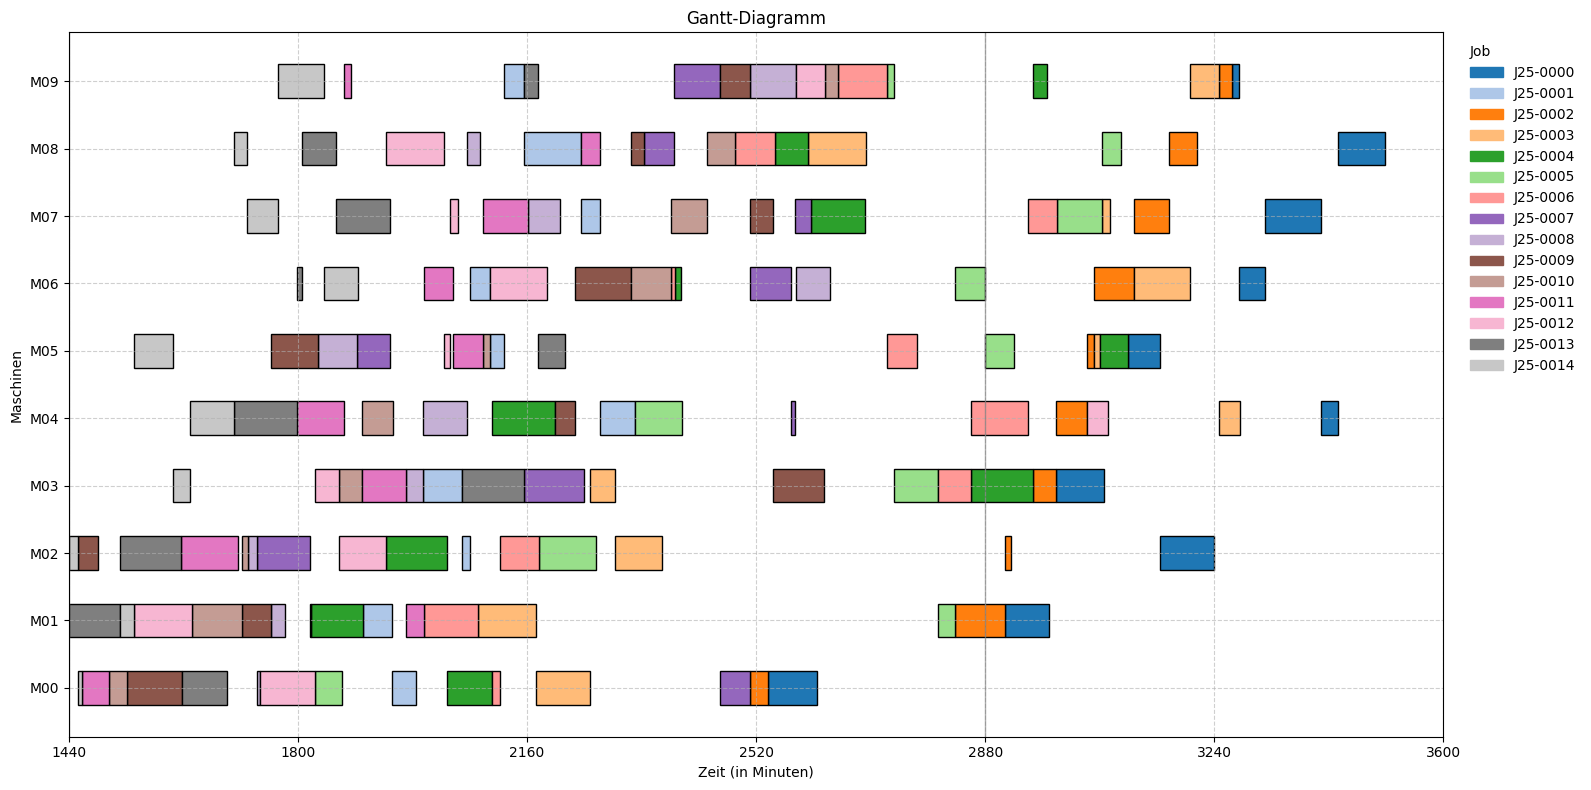

In [10]:
gantt.get_plot(df_schedule, perspective="Machine")

In [11]:
df_schedule
df_schedule_info = pd.merge(df_schedule, df_jobs_times, on="Job", how="right")
check.all_in_one(df_schedule_info)


+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True